In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
trip_start_date = dt.date(2018,6,21)
trip_end_date = dt.date(2018,6,30)

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

past_twelve_months = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
past_twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

# Exploratory Climate Analysis

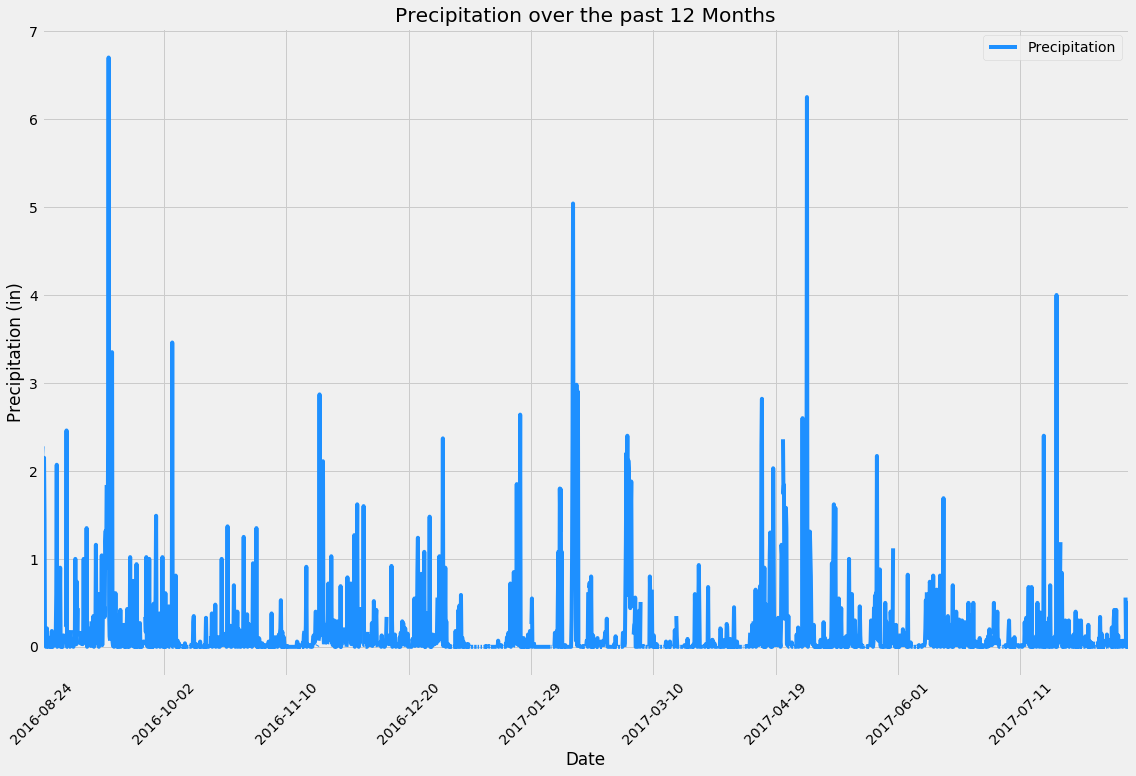

In [15]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
Weather = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_twelve_months).filter(Measurement.date <= most_recent_date).order_by(Measurement.date).all()

#Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precipitation = pd.DataFrame(Weather, columns=['Date','Precipitation'])

#Save the query results as a Pandas DataFrame and set the index to the date
#Sort the dataframe by date
precipitation.set_index('Date', inplace=True)

#Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot(figsize=(16, 11), x_compat=True, color='dodgerblue')

plt.title("Precipitation over the past 12 Months")
plt.ylabel("Precipitation (in)")
plt.xticks(rotation='45')
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("./Images/Precipitation.png")
plt.show()

In [16]:
precipitation.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


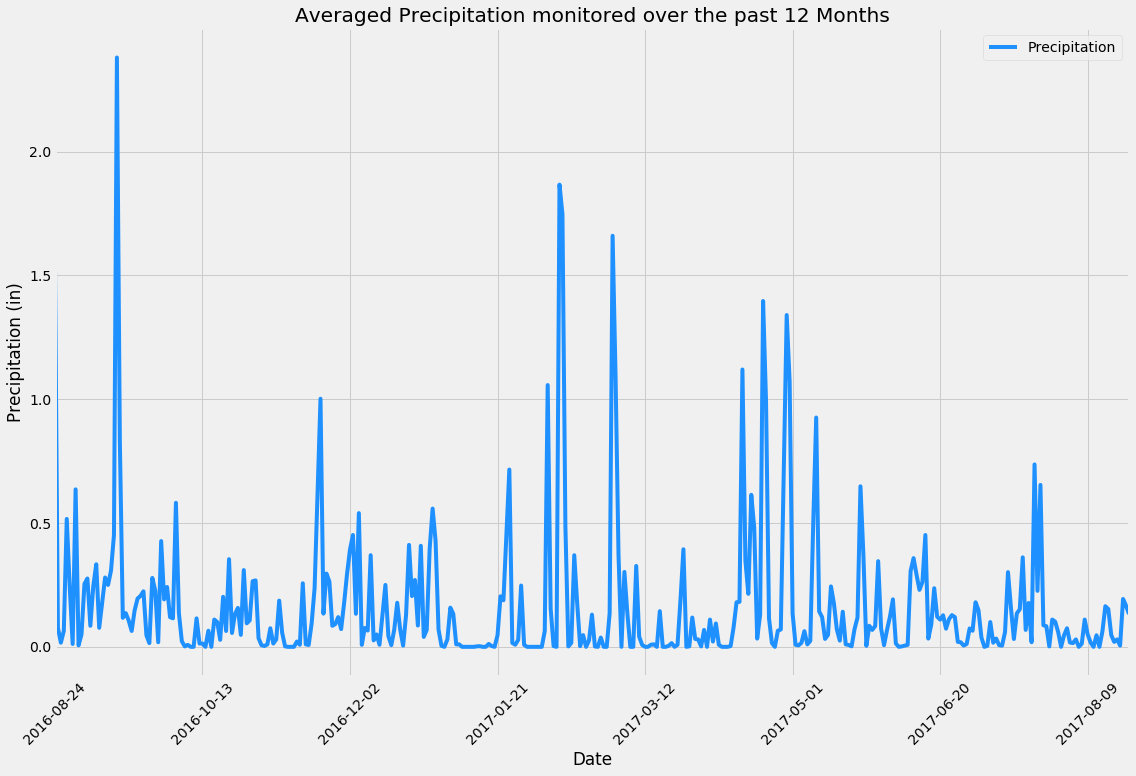

In [17]:
Weather_1 = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date >= past_twelve_months).filter(Measurement.date <= most_recent_date).group_by(Measurement.date).order_by(Measurement.date).all()
precip_1 = pd.DataFrame(Weather_1, columns=['Date','Precipitation'])

#Save the query results as a Pandas DataFrame and set the index to the date
#Sort the dataframe by date
precip_1.set_index('Date', inplace=True)

#Use Pandas Plotting with Matplotlib to plot the data
precip_1.plot(figsize=(16, 11), x_compat=True, color='dodgerblue')

plt.title("Averaged Precipitation monitored over the past 12 Months")
plt.ylabel("Precipitation (in)")
plt.xticks(rotation='45')
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("./Images/Avg_Precipitation.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
precip_1.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [21]:
# Design a query to show how many stations are available in this dataset?
Count = session.query(Station.name).count()
Count

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= past_twelve_months)
temp_df = pd.DataFrame(temp_df)
temp_df.set_index('station', inplace=True)
temp_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


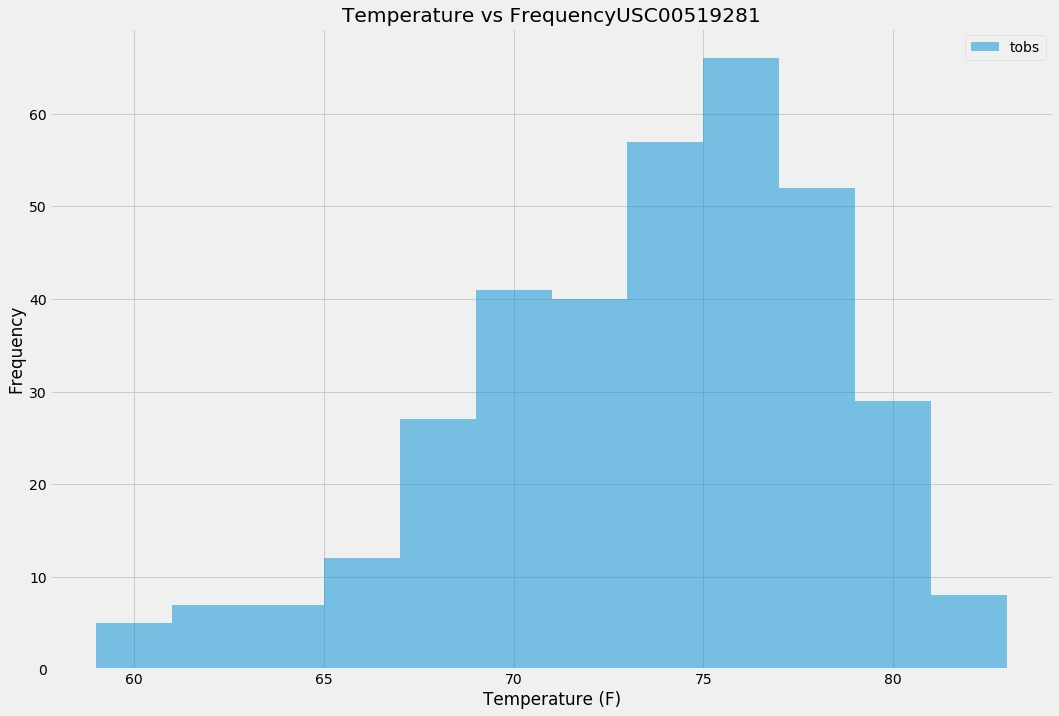

In [28]:
temp_df.plot.hist(by='station', bins=12, figsize=(16,11), alpha=0.5)
plt.title("Temperature vs Frequency" + (most_active_station))
plt.xlabel("Temperature (F)")
plt.savefig("./Images/StationTemps.png")
plt.show()

In [30]:
June_obvs = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").group_by(Measurement.date).limit(217).all()
December_obvs = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").group_by(Measurement.date).all()

print(stats.ttest_rel(June_obvs, December_obvs))
#Paired t-test because the temperatures are tallied in Hawaii
print("----"*20)
print("The paired t-test is due to the temperatures are tallied in Hawaii only and that the weather has similar independent variables. The temperatures fluctuate depending on what time of the year it is. In conclusion of this histogram the t-test p-value is placed under 0.05 which means that the hypothesis is false meaning that Hawaii has mild temperatures year round")

Ttest_relResult(statistic=array([17.57826913]), pvalue=array([1.55642724e-43]))
--------------------------------------------------------------------------------
The paired t-test is because the temperatures are tallied in Hawaii only and that the weather has similar independent variables. The temperatures fluctuate depending on what time of the year it is. In conclusion of this histogram the t-test p-value is placed under 0.05 which means that the hypothesis is false meaning that Hawaii has mild temperatures year round


In [31]:
#This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
#and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):   
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#function usage example
print(f"June: {calc_temps('2016-06-01', '2016-06-31')}")
print(f"December: {calc_temps('2016-12-01', '2016-12-31')}")

June: [(64.0, 75.17525773195877, 81.0)]
December: [(60.0, 71.13, 78.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-06-21', '2017-06-30')
trip_results

[(71.0, 77.19354838709677, 82.0)]

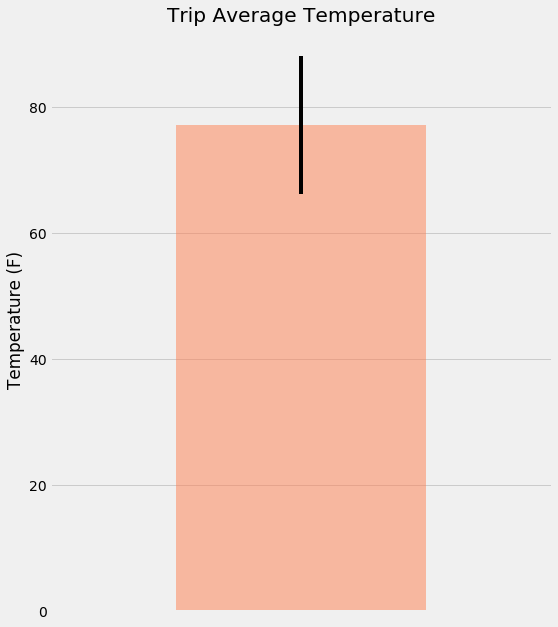

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trips_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trips_df['Avg Temp']
min_max_temp = trips_df.iloc[0]['Max Temp'] - trips_df.iloc[0]['Min Temp']
avg_temp.plot.bar(yerr=min_max_temp, figsize=(8,10), alpha=0.5, color='coral')
plt.title("Trip Average Temperature")
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.savefig("./Images/TripTemp.png")
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= '2017-06-21').filter(Measurement.date <= '2017-06-30').\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.18),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.8300000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.3),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.14),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.12000000000000001),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0)]

# Optional Challenge Assignment

In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, TMIN, TAVG, and TMAX
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [43]:
# calculate the daily normals for your trip
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start_date, trip_end_date)
# Stip off the year and save a list of %m-%d strings
date_generated = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for trip_date in date_generated:
    normals.append(*daily_normals(trip_date))
temp_hist_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_hist_df['Date'] = trip_dates
temp_hist_df = temp_hist_df.set_index('Date')
temp_hist_df

,tmin,tavg,tmax
Date,,,
2018-06-21,68.0,74.758621,82.0
2018-06-22,69.0,75.157895,81.0
2018-06-23,68.0,74.543860,80.0
2018-06-24,68.0,74.964286,84.0
2018-06-25,68.0,74.103448,80.0
2018-06-26,67.0,74.214286,82.0
2018-06-27,66.0,75.017857,81.0
2018-06-28,69.0,74.886792,80.0
2018-06-29,67.0,74.915254,80.0


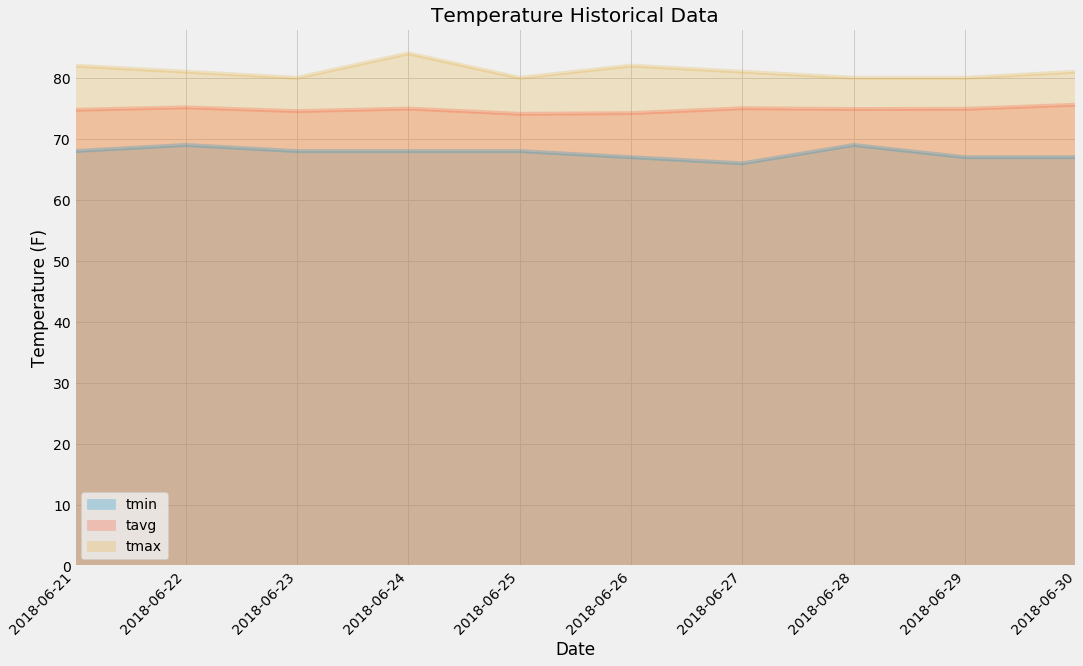

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
temp_hist_df.plot.area(figsize=(16,11), stacked=False, x_compat=True, title = 'Temperature Historical Data', rot='45', alpha=0.25)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.savefig("./Images/Predicted Temps.png")
plt.show()